In [1]:
import numpy as np
import os
import sys
from matplotlib.ticker import FormatStrFormatter
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from jax import device_get
import jax
import jax.numpy as jnp
import torch
from torch import Tensor
sys.path.append(os.path.expanduser("~"))
from UNet_apply import applyCNN, applyCNN_TF
from TF_utils import *
import Pk_library as PKL

[rank: 0] Seed set to 7


cuda
1
cuda


CometLogger will be initialized in online mode


suite: Astrid


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [2]:
def rcc_compare(sim, s, res, z, simulation_index, model='GP'):
    if z == '0.47':
        z2 = '0.5'
    elif z == '0.95':
        z2 = '1.0'
    elif z == '1.48':
        z2 = '1.5'
    else:
        z2 = z
    CC_k, CC = getCrossCorrelations(sim, s, res, z2)
    mask = CC_k <= 10
    filtered_CC_k = CC_k[mask]
    filtered_CC = CC[:, mask]
    
    k, PkRatios = getPkRatios(sim, s, res, z)
    mask_2 = k[0] <= 10
    filtered_k = k[:, mask_2]
    filtered_PkRatios = PkRatios[:, mask_2]
    
    tolerance = 0.1
    close_to_1_mask = np.all(np.abs(filtered_CC - 1) < tolerance, axis=1)
    different_from_1_mask = np.any(np.abs(filtered_PkRatios - 1) > tolerance, axis=1)
    result_indices = np.where(close_to_1_mask & different_from_1_mask)[0]
    
    post_fit_ratios = getGP_post_fit(sim, s, res, z, smoothed=False)
    if sim == 'Astrid' and s == 'LH' and res == 256 and z == '0.0':
        distances = np.linalg.norm(post_fit_ratios - filtered_PkRatios[simulation_index], axis=1)
        post_fit_index = np.argmin(distances)
    else:
        post_fit_index = simulation_index
    print(simulation_index)
    print(post_fit_index)
    #print(post_fit_ratios[post_fit_index].shape) #(39,)

    
    _, NBody_grid, NBody_mean = getGrid(sim, s, res, z2, 'nbody', simulation_index)
    _, hydro_grid, hydro_mean = getGrid(sim, s, res, z2, 'hydro', simulation_index)
    
    #Load Model
    if model == 'GP':
        postTF_grid = applyTF(NBody_grid, filtered_k[0], post_fit_ratios[post_fit_index], 256, 25.0) #overdensity
    elif model == 'CNN':
        Nbody_map = np.mean(np.array(NBody_grid), axis = 2) + 1
        residual_grid, postTF_grid_ = applyCNN(torch.tensor(Nbody_map[np.newaxis,np.newaxis,:])) #torch.Size([1, 1, 1, 256, 256])
        postTF_grid = postTF_grid_.detach().numpy() - 1
    elif model == 'CNN_TF':
        Nbody_map = np.mean(np.array(NBody_grid), axis = 2) + 1
        residual_grid = applyCNN_TF(torch.tensor(Nbody_map[np.newaxis,np.newaxis,:])) #torch.Size([1, 1, 1, 256, 256])
        postTF_grid = applyTF_2D(Nbody_map -1, filtered_k[0], post_fit_ratios[post_fit_index], 256, 25.0)  + residual_grid.detach().numpy() #overdensity
        
    #Pk calculations
    grid    = 256     #the map will have grid^2 pixels
    BoxSize = 25 #Mpc/h
    MAS     = 'None'  #MAS used to create the image; 'NGP', 'CIC', 'TSC', 'PCS' o 'None'
    threads = 1       #number of openmp threads
    axis = 0
    verbose = False
    if model == 'GP':
        Pk3D_hydro = PKL.Pk(hydro_grid, BoxSize, axis, MAS, threads, verbose)
        Pk3D_Nbody = PKL.Pk(NBody_grid, BoxSize, axis, MAS, threads, verbose)
        Pk3D_postTF = PKL.Pk(np.array(postTF_grid, dtype=np.float32), BoxSize, axis, MAS, threads, verbose)
        k_Hydro   = Pk3D_hydro.k3D
        Pk_Hydro   = Pk3D_hydro.Pk[:,0]
        k_NBody   = Pk3D_Nbody.k3D
        Pk_NBody   = Pk3D_Nbody.Pk[:,0]
        k_postTF   = Pk3D_postTF.k3D
        Pk_postTF   = Pk3D_postTF.Pk[:,0]
         #post-fit Cross-correlation  -- confirmed its consistent with saved Rcc in getCrossCorrelations
        Pkcc = PKL.XPk([hydro_grid,np.array(postTF_grid, dtype=np.float32)],  BoxSize, axis, MAS=[MAS,MAS], threads=1) 
        kcc   = Pkcc.k3D
        Pk0_X  = Pkcc.XPk[:,0,0] #monopole of 1-2 cross P(k)
        Pk0_X /= np.sqrt(Pk_Hydro*Pk_postTF)
        #k_postTF, Pk_postTF = power_spectrum(postTF_grid, 256, box_size, kmin=np.pi/box_size, dk=2*np.pi/box_size, boxsize=np.array([box_size] * 3))
        #k_residual, Pk_residual = power_spectrum(hydro_grid - postTF_grid, 256, box_size, kmin=np.pi/box_size, dk=2*np.pi/box_size, boxsize=np.array([box_size] * 3))
        #k_NBody, Pk_NBody = power_spectrum(NBody_grid, 256, box_size, kmin=np.pi/box_size, dk=2*np.pi/box_size, boxsize=np.array([box_size] * 3))
        #k_Hydro, Pk_Hydro = power_spectrum(hydro_grid, 256, box_size, kmin=np.pi/box_size, dk=2*np.pi/box_size, boxsize=np.array([box_size] * 3))
    else:
        Pk2D_hydro = PKL.Pk_plane(np.mean(np.array(hydro_grid), axis = 2), BoxSize, MAS, threads, verbose)
        Pk2D_Nbody = PKL.Pk_plane(np.mean(np.array(NBody_grid), axis = 2), BoxSize,  MAS, threads, verbose)
        Pk2D_postTF = PKL.Pk_plane(np.array(postTF_grid, dtype=np.float32), BoxSize, MAS, threads, verbose) 
        k_Hydro   = Pk2D_hydro.k
        Pk_Hydro   = Pk2D_hydro.Pk
        k_NBody   = Pk2D_Nbody.k
        Pk_NBody   = Pk2D_Nbody.Pk
        k_postTF   = Pk2D_postTF.k
        Pk_postTF   = Pk2D_postTF.Pk
        #post-fit Cross-correlation -- more wiggly, slightly under saved Rcc from k~8
        Pkcc = PKL.XPk_plane(np.mean(np.array(hydro_grid), axis = 2),np.array(postTF_grid, dtype=np.float32),  BoxSize, MAS,MAS, threads=1) 
        kcc   = Pkcc.k
        Pk0_X = Pkcc.r
        #k_postTF, Pk_postTF = power_spectrum(postTF_grid, 256, box_size, kmin=np.pi/box_size, dk=2*np.pi/box_size, boxsize=np.array([box_size] * 2))
        #k_residual, Pk_residual = power_spectrum(residual_grid.detach().numpy(), 256, box_size, kmin=np.pi/box_size, dk=2*np.pi/box_size, boxsize=np.array([box_size] * 2))
        #k_NBody, Pk_NBody = power_spectrum(np.mean(np.array(NBody_grid), axis = 2), 256, box_size, kmin=np.pi/box_size, dk=2*np.pi/box_size, boxsize=np.array([box_size] * 2))
        #k_Hydro, Pk_Hydro = power_spectrum(np.mean(np.array(hydro_grid), axis = 2), 256, box_size, kmin=np.pi/box_size, dk=2*np.pi/box_size, boxsize=np.array([box_size] * 2))
    
    return filtered_CC_k, filtered_CC[simulation_index], kcc[kcc <= 10],  Pk0_X[kcc <= 10], k_NBody[k_NBody<= 10], Pk_NBody[k_NBody<= 10], Pk_Hydro[k_NBody<= 10], Pk_postTF[k_NBody<= 10], filtered_k[0], filtered_PkRatios[simulation_index]

In [3]:
def compare_Rcc_TF(sim_indx):
    filtered_CC_k, saved_CC, kcc_postTF,  Pk0_X_postTF, filtered_k, Pnbody, Phydro, Pfit, k_saved,PkRatio  = rcc_compare('Astrid', 'LH', 256, '0.0', sim_indx, 'GP')
    filtered_CC_k, saved_CC, kcc_CNN,  Pk0_X_CNN, filtered_k_CNN, Pnbody_CNN, Phydro_CNN, Pfit_CNN, k_saved,PkRatio = rcc_compare('Astrid', 'LH', 256, '0.0', sim_indx, 'CNN')
    filtered_CC_k, saved_CC, kcc_CNNTF,  Pk0_X_CNNTF, filtered_k_CNNTF, Pnbody_CNNTF, Phydro_CNNTF, Pfit_CNNTF, k_saved,PkRatio = rcc_compare('Astrid', 'LH', 256, '0.0', sim_indx, 'CNN_TF')

    plt.figure()
    plt.plot(kcc_postTF,Pk0_X_postTF,label = 'hydro-GP TF')
    plt.plot(kcc_CNN,Pk0_X_CNN, label = 'hydro-CNN')
    plt.plot(kcc_CNNTF,Pk0_X_CNNTF,label = 'hydro-CNN+TF')
    plt.plot(filtered_CC_k, saved_CC,'--', label = 'hydro-nbody' , color = 'r')
    plt.xscale('log')
    plt.xlabel(r'k [h Mpc$^{-1}$]', fontsize=20)
    plt.ylabel(r'r$_{cc}$', fontsize=20)
    plt.title('z={}, simulation {}'.format(0.0,sim_indx))
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(filtered_k, Pfit/Pnbody, label='GP TF')
    plt.plot(filtered_k_CNN, (Pfit_CNN/Pnbody_CNN), label='CNN')
    plt.plot(filtered_k_CNNTF, (Pfit_CNNTF/Pnbody_CNNTF), label='CNN TF')
    plt.plot(k_saved, PkRatio, '--', label='Hydro/Nbody' , color = 'r') #confirmed same as Pk_Hydro/Pk_NBody
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'k [h Mpc$^{-1}$]', fontsize=20)
    plt.ylabel(r'P$_{hydro}$(k) / P$_{nbody}$(k)', fontsize=20)
    plt.legend(fontsize='xx-large')
    plt.tight_layout()
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)
    plt.tight_layout()
    plt.show()

In [4]:
def Pk_error(sim_indx):
    error_postTF = []
    error_CNN = []
    error_CNNTF = []
    rcc_postTF = []
    rcc_CNN = []
    rcc_CNNTF =[]
    for i in sim_indx:
        filtered_CC_k, saved_CC, kcc_postTF,  Pk0_X_postTF, filtered_k, Pnbody, Phydro, Pfit, k_saved,PkRatio  = rcc_compare('Astrid', 'LH', 256, '0.0', i, 'GP')
        filtered_CC_k, saved_CC, kcc_CNN,  Pk0_X_CNN, filtered_k_CNN, Pnbody_CNN, Phydro_CNN, Pfit_CNN, k_saved,PkRatio = rcc_compare('Astrid', 'LH', 256, '0.0', i, 'CNN')
        filtered_CC_k, saved_CC, kcc_CNNTF,  Pk0_X_CNNTF, filtered_k_CNNTF, Pnbody_CNNTF, Phydro_CNNTF, Pfit_CNNTF, k_saved,PkRatio = rcc_compare('Astrid', 'LH', 256, '0.0', i, 'CNN_TF')

        error_postTF.append(100*(Phydro-Pfit)/Phydro)
        error_CNN.append(100*(Phydro_CNN-Pfit_CNN)/Phydro_CNN)
        error_CNNTF.append(100*(Phydro_CNNTF-Pfit_CNNTF)/Phydro_CNNTF)
        rcc_postTF.append(Pk0_X_postTF)
        rcc_CNN.append(Pk0_X_CNN)
        rcc_CNNTF.append(Pk0_X_CNNTF)
        
    plt.figure()
    median_spectrum = np.mean(error_postTF, axis=0)
    min_spectrum = np.percentile(error_postTF, 5, axis=0)
    max_spectrum = np.percentile(error_postTF, 95, axis=0)
    plt.plot(filtered_k, median_spectrum, color='b',label='GP TF')
    plt.fill_between(filtered_k, min_spectrum, max_spectrum, color='b', alpha=0.1)
    median_spectrum = np.mean(error_CNN, axis=0)
    min_spectrum = np.percentile(error_CNN, 5, axis=0)
    max_spectrum = np.percentile(error_CNN, 95, axis=0)
    plt.plot(filtered_k_CNN, median_spectrum, color='orange',label='CNN')
    plt.fill_between(filtered_k_CNN, min_spectrum, max_spectrum, color='orange', alpha=0.1)
    median_spectrum = np.mean(error_CNNTF, axis=0)
    min_spectrum = np.percentile(error_CNNTF, 5, axis=0)
    max_spectrum = np.percentile(error_CNNTF, 95, axis=0)
    plt.plot(filtered_k_CNNTF, median_spectrum, color='g',label='CNN+TF')
    plt.fill_between(filtered_k_CNNTF, min_spectrum, max_spectrum, color='g', alpha=0.1)
    plt.axhline(ls=':',c='k')
    # Fill the area between the minimum and maximum power spectra

    plt.xscale('log')
    plt.xlabel(r'k [h Mpc$^{-1}$]', fontsize=16)
    plt.ylabel(r'Percent Error of P$_{hydro}$(k)', fontsize=16)
    plt.xticks(fontsize=14)  
    plt.yticks(fontsize=14) 
    plt.legend(fontsize='large')
    plt.tight_layout()
    plt.show()
    
    plt.figure()
    median_spectrum = np.mean(rcc_postTF, axis=0)
    min_spectrum = np.percentile(rcc_postTF, 5, axis=0)
    max_spectrum = np.percentile(rcc_postTF, 95, axis=0)
    plt.plot(kcc_postTF, median_spectrum, color='r',label='Hydro/Nbody =GP TF')
    plt.fill_between(kcc_postTF, min_spectrum, max_spectrum, color='r', alpha=0.1)
    median_spectrum = np.mean(rcc_CNN, axis=0)
    min_spectrum = np.percentile(rcc_CNN, 5, axis=0)
    max_spectrum = np.percentile(rcc_CNN, 95, axis=0)
    plt.plot(kcc_CNN, median_spectrum, color='orange',label='CNN')
    plt.fill_between(kcc_CNN, min_spectrum, max_spectrum, color='orange', alpha=0.1)
    median_spectrum = np.mean(rcc_CNNTF, axis=0)
    min_spectrum = np.percentile(rcc_CNNTF, 5, axis=0)
    max_spectrum = np.percentile(rcc_CNNTF, 95, axis=0)
    plt.plot(kcc_CNNTF, median_spectrum, color='g',label='CNN+TF')
    plt.fill_between(kcc_CNNTF, min_spectrum, max_spectrum, color='g', alpha=0.1)
    # Fill the area between the minimum and maximum power spectra

    plt.xscale('log')
    plt.xlabel(r'k [h Mpc$^{-1}$]', fontsize=20)
    plt.ylabel(r'r$_{cc}$', fontsize=20)
    plt.title('z={}'.format(0.0))
    plt.legend()
    plt.show()


0
146


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.



Computing power spectra of the fields...
Time FFTS = 0.14
Time loop = 0.57
Time taken = 0.72 seconds
0
146
suite: Astrid


/global/homes/l/lindajin/UNet_apply.py:241: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict=torch.load(ckpt)["state_dict"]



Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds
0
146
suite: Astrid


/global/homes/l/lindajin/UNet_apply.py:269: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict=torch.load(ckpt)["state_dict"]



Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds
50
112

Computing power spectra of the fields...
Time FFTS = 0.14
Time loop = 0.58
Time taken = 0.72 seconds
50
112
suite: Astrid

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds
50
112
suite: Astrid

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds
100
118

Computing power spectra of the fields...
Time FFTS = 0.14
Time loop = 0.58
Time taken = 0.73 seconds
100
118
suite: Astrid

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds
100
118
suite: Astrid

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds
150
165

Computing power spectra of the fields...
Time FFTS = 0.14
Time loop = 0.57
Time taken = 0.72 seconds
150
165
suite: Astrid

Computing power spectra of the fields...
Time FFTS =

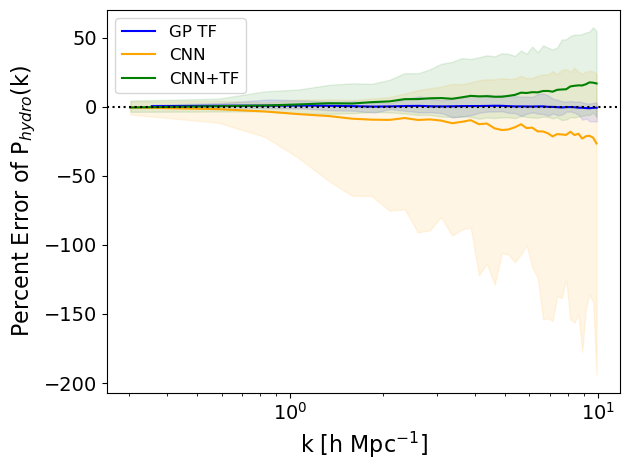

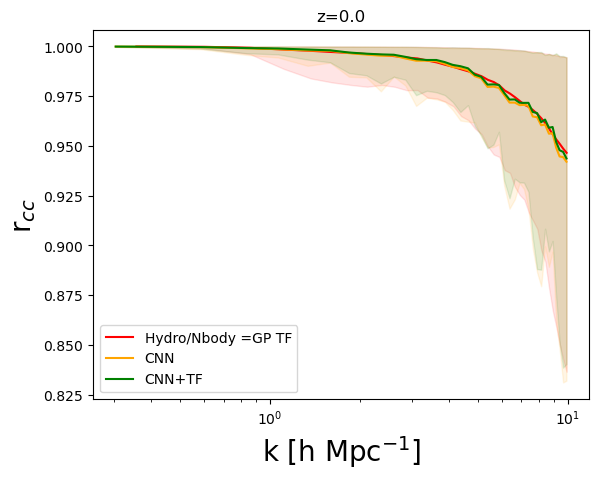

In [5]:
Pk_error(np.arange(0,1000,50))

10
173

Computing power spectra of the fields...
Time FFTS = 0.14
Time loop = 0.58
Time taken = 0.73 seconds
10
173
suite: Astrid

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds
10
173
suite: Astrid

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds


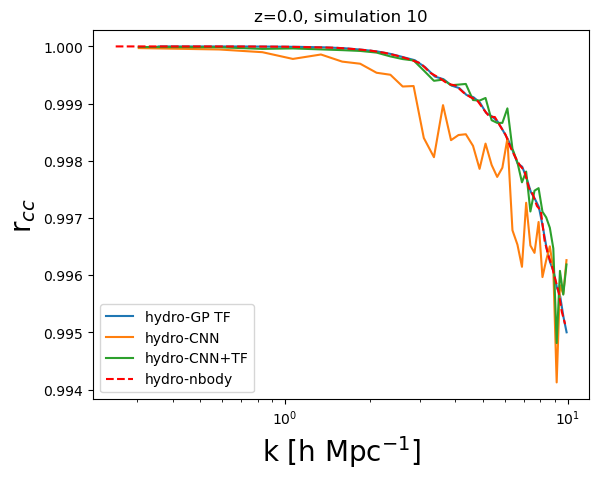

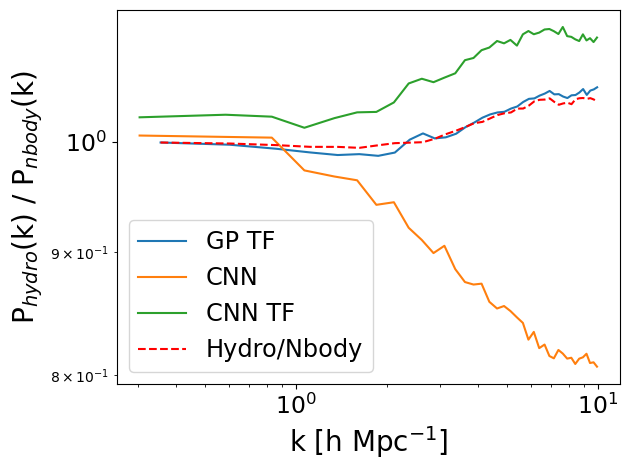

30
151

Computing power spectra of the fields...
Time FFTS = 0.17
Time loop = 0.62
Time taken = 0.79 seconds
30
151
suite: Astrid

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds
30
151
suite: Astrid

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds


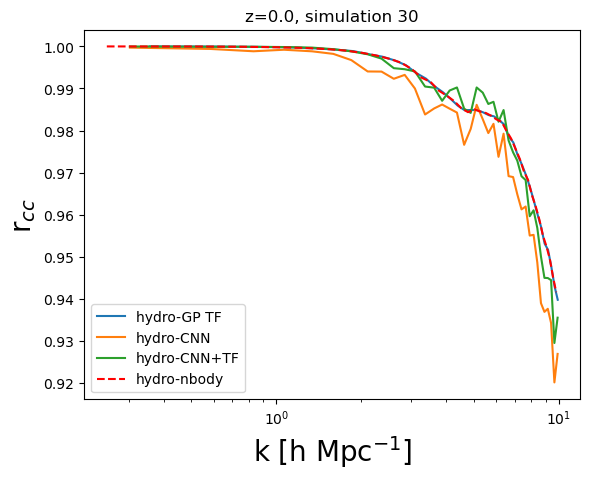

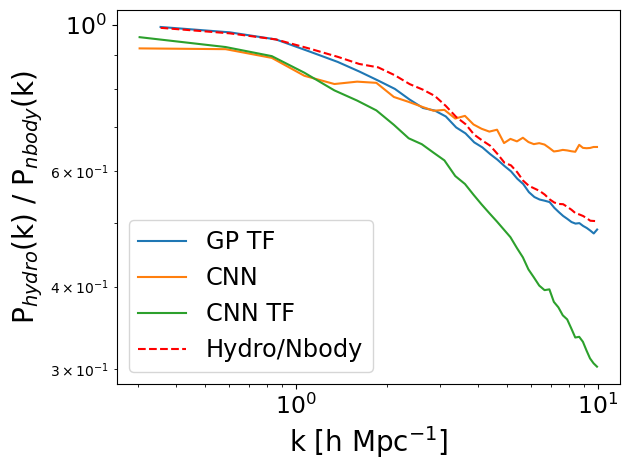

100
118

Computing power spectra of the fields...
Time FFTS = 0.14
Time loop = 0.63
Time taken = 0.78 seconds
100
118
suite: Astrid

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds
100
118
suite: Astrid

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds


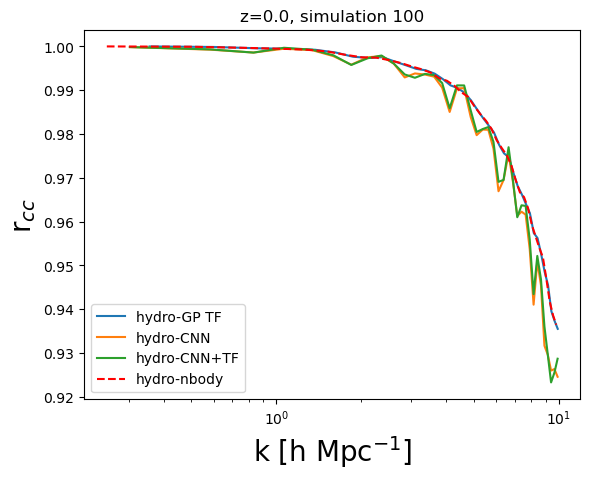

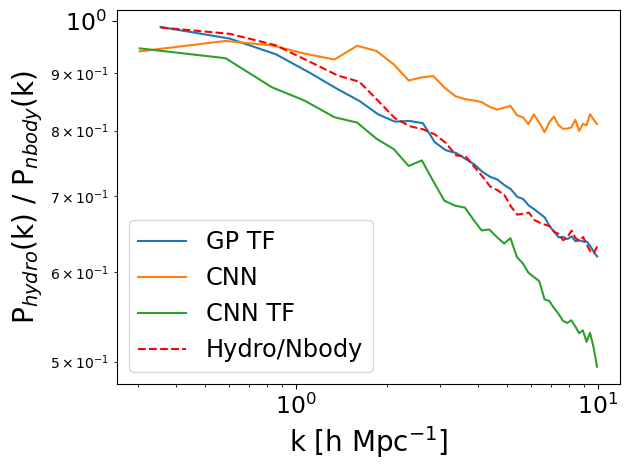

200
61

Computing power spectra of the fields...
Time FFTS = 0.14
Time loop = 0.62
Time taken = 0.77 seconds
200
61
suite: Astrid

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds
200
61
suite: Astrid

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds


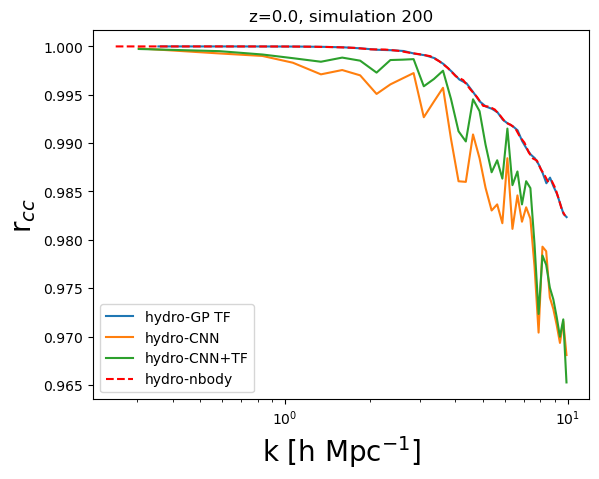

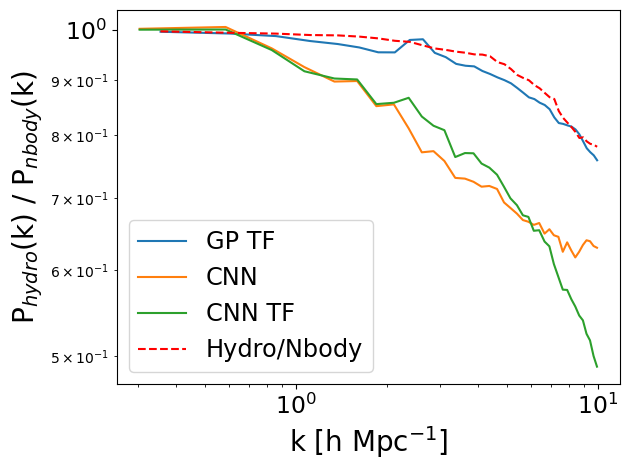

500
110

Computing power spectra of the fields...
Time FFTS = 0.14
Time loop = 0.63
Time taken = 0.78 seconds
500
110
suite: Astrid

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds
500
110
suite: Astrid

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds


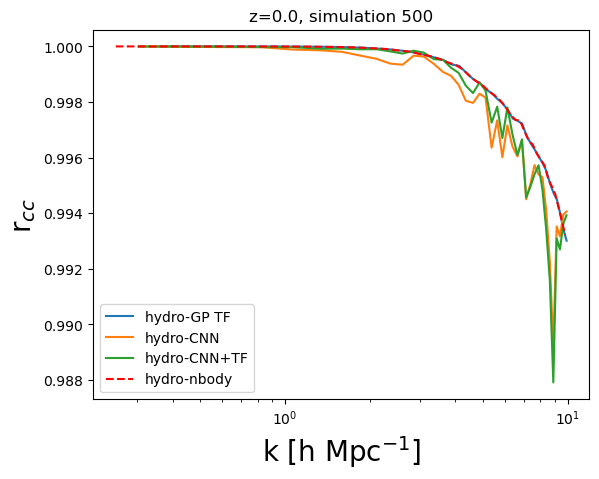

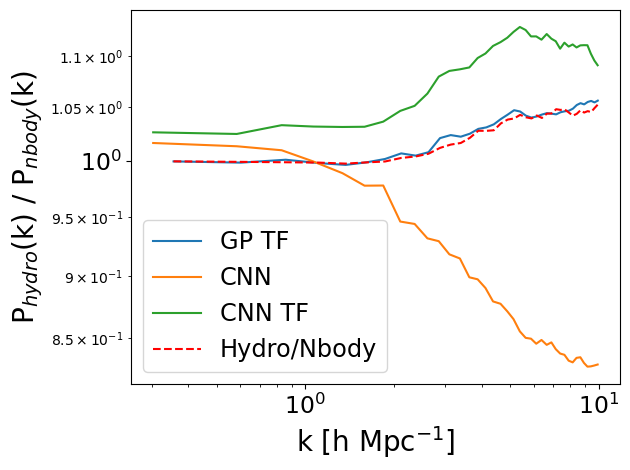

800
123

Computing power spectra of the fields...
Time FFTS = 0.14
Time loop = 0.61
Time taken = 0.76 seconds
800
123
suite: Astrid

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds
800
123
suite: Astrid

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds


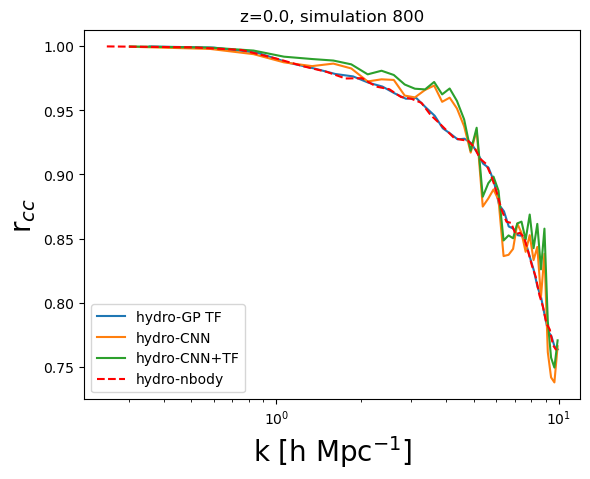

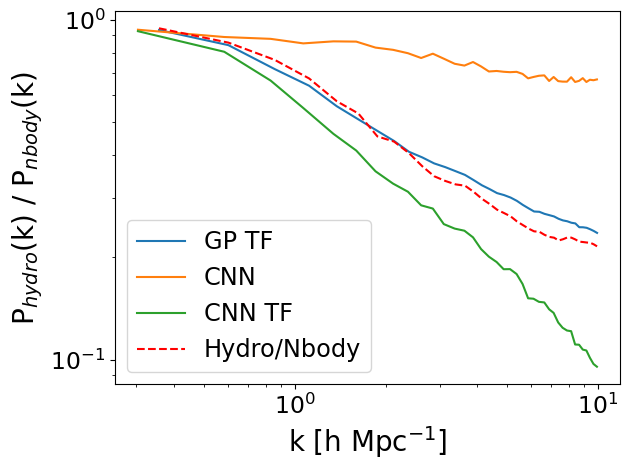

900
17

Computing power spectra of the fields...
Time FFTS = 0.15
Time loop = 0.62
Time taken = 0.77 seconds
900
17
suite: Astrid

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds
900
17
suite: Astrid

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds


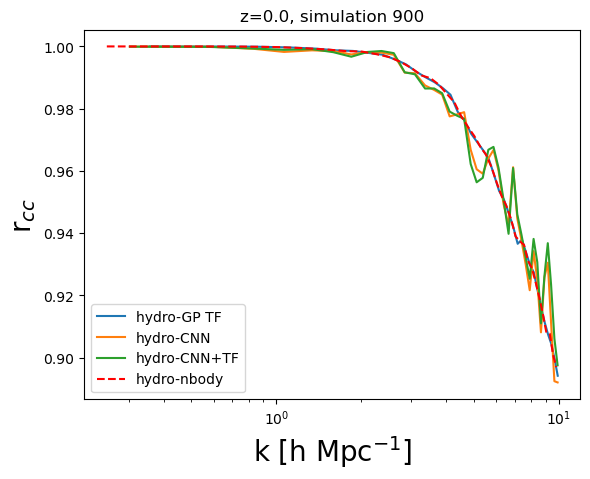

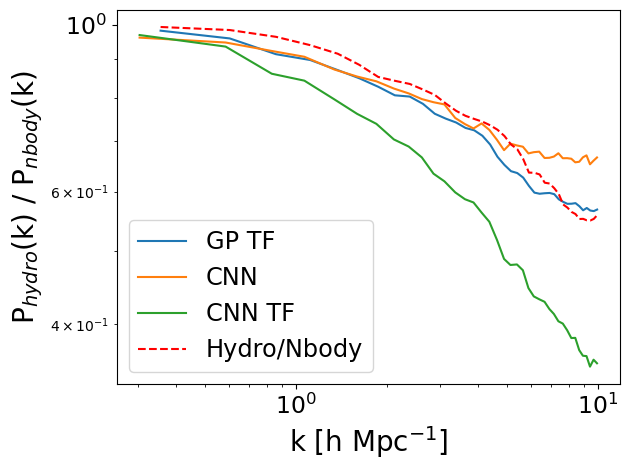

999
181

Computing power spectra of the fields...
Time FFTS = 0.15
Time loop = 0.63
Time taken = 0.78 seconds
999
181
suite: Astrid

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds
999
181
suite: Astrid

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds


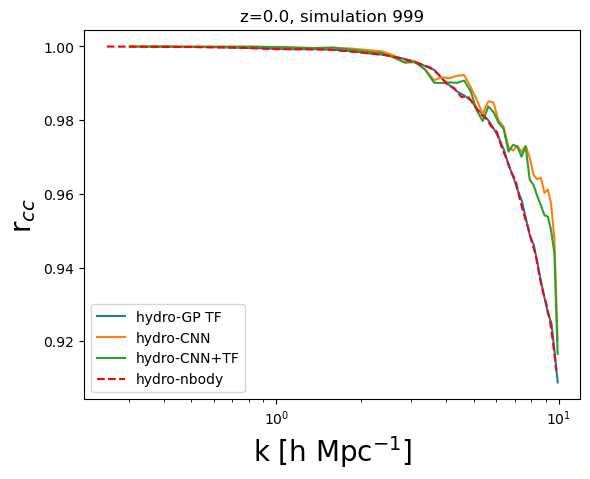

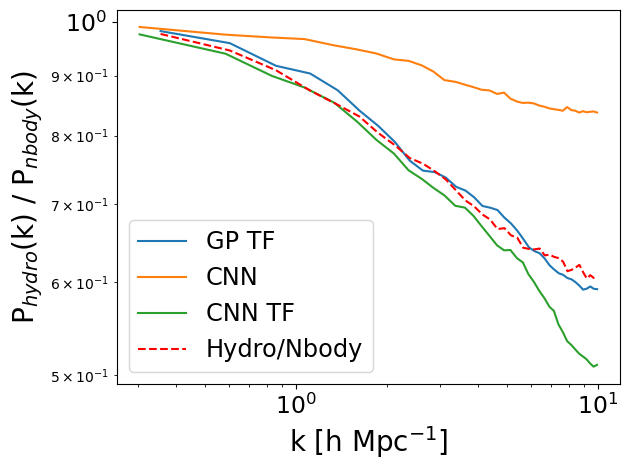

In [7]:
compare_Rcc_TF(10)
compare_Rcc_TF(30)
compare_Rcc_TF(100)
compare_Rcc_TF(200)
compare_Rcc_TF(500)
compare_Rcc_TF(800)
compare_Rcc_TF(900)
compare_Rcc_TF(999)